<a href="https://colab.research.google.com/github/biswa-13/Python-Tutorials/blob/master/Faster_R_CNN_Demo39_SignLanguageDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Reference : https://github.com/RomRoc/objdet_train_tensorflow_colab/blob/master/objdet_custom_tf_colab.ipynb
# Installing required packages

!git clone --quiet https://github.com/tensorflow/models.git
!apt-get install -qq protobuf-compiler python-tk
!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive
!pip install -q pycocotools
!pip install pillow
!pip install lxml
!pip install Cython
!pip install jupyter
!pip install matplotlib
!pip install pandas
!pip install opencv-python
!pip install tensorflow

In [36]:
import tensorflow as tf
print(tf.__version__)
%cd /content/models/research/
print(os.getcwd())
%rm -rf heraclesLab/


print(os.listdir())

1.14.0
/content/models/research
/content/models/research
['morph_net', 'deep_speech', 'a3c_blogpost', 'adversarial_crypto', 'audioset', 'deeplab', 'fivo', 'rebar', 'vid2depth', 'adversarial_logit_pairing', 'pcl_rl', 'nst_blogpost', 'swivel', 'seq2species', 'video_prediction', 'brain_coder', 'global_objectives', 'lstm_object_detection', 'lfads', 'compression', 'cognitive_planning', 'textsum', 'delf', 'maskgan', 'domain_adaptation', 'tcn', 'lm_commonsense', 'adv_imagenet_models', 'autoencoder', 'differential_privacy', 'neural_gpu', 'next_frame_prediction', 'keypointnet', 'setup.py', 'ptn', 'im2txt', 'cvt_text', 'adversarial_text', 'qa_kg', 'sentiment_analysis', 'gan', 'steve', 'slim', 'README.md', 'tensorrt', 'learned_optimizer', 'object_detection', 'neural_programmer', 'lexnet_nc', 'struct2depth', 'astronet', 'marco', 'attention_ocr', 'efficient-hrl', 'namignizer', 'minigo', 'street', 'skip_thoughts', 'syntaxnet', 'autoaugment', 'learning_to_remember_rare_events', 'lm_1b', 'transformer'

In [0]:



import os
#crntFldr = os.getcwd() #content
#reseacrhFldr = crntFldr+"/models/research"
%cd "/content/models/research"
!protoc object_detection/protos/*.proto --python_out=.
import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'
!python object_detection/builders/model_builder_test.py




In [37]:
# Preparing the Dataset
!mkdir heraclesLab
%cd /content/models/research/heraclesLab
#!printf "item {\n id:1 \n name: 'dog'\n}" > dog_map.pbtxt
fileId = '12lULVH7JhOhb8Gvom8DuhkJkA6VjxywB'
          

import os
from zipfile import ZipFile
from shutil import  copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted Zip File is -->',fileName)

image_files = os.listdir('images')
img_files = [x.split('.')[0] for x in image_files]

with open('annotations/trainval.txt', 'w') as text_file:
  for row in img_files:
    print("row -->",row)
    text_file.write(row+ '\n')
   # if(row != "dog_014"):
    #  print("row -->",row)
      

/content/models/research/heraclesLab
Extracted Zip File is --> 12lULVH7JhOhb8Gvom8DuhkJkA6VjxywB.zip
row --> ten_1041
row --> eight_861
row --> four_452
row --> three_321
row --> eight_841
row --> seven_762
row --> two_211
row --> eight_821
row --> seven_712
row --> one_141
row --> three_331
row --> five_522
row --> seven_741
row --> eight_811
row --> five_532
row --> three_381
row --> seven_781
row --> six_621
row --> nine_911
row --> eight_822
row --> six_642
row --> seven_722
row --> six_672
row --> eight_812
row --> five_572
row --> seven_752
row --> three_372
row --> five_542
row --> two_281
row --> four_412
row --> nine_952
row --> seven_782
row --> one_122
row --> five_512
row --> three_311
row --> five_541
row --> seven_761
row --> nine_932
row --> four_451
row --> one_152
row --> four_442
row --> two_212
row --> six_641
row --> nine_912
row --> one_142
row --> four_482
row --> ten_1031
row --> nine_972
row --> one_161
row --> nine_941
row --> four_432
row --> three_371
row -->

In [47]:
# Empty png files
# Create empty png mask files to avoid error in 
# create_pet_tf_record.py, they are not used in training model.
%cd /content/models/research/heraclesLab/annotations
!rm trimaps -r
!mkdir trimaps

from PIL import Image
image = Image.new('RGB', (640, 480))

for filename in os.listdir('/content/models/research/heraclesLab/annotations/xmls'):
  filename = os.path.splitext(filename)[0]
  print("filename -->",filename)
  image.save('trimaps/'+filename+'.png')

/content/models/research/heraclesLab/annotations
filename --> five_522
filename --> two_221
filename --> one_131
filename --> one_181
filename --> nine_962
filename --> six_622
filename --> five_571
filename --> one_141
filename --> four_451
filename --> four_452
filename --> eight_842
filename --> eight_852
filename --> two_211
filename --> three_312
filename --> eight_872
filename --> one_122
filename --> seven_732
filename --> nine_922
filename --> nine_912
filename --> five_532
filename --> four_422
filename --> nine_982
filename --> five_552
filename --> one_142
filename --> ten_1072
filename --> four_442
filename --> five_521
filename --> six_682
filename --> two_251
filename --> five_581
filename --> three_372
filename --> seven_781
filename --> nine_941
filename --> six_612
filename --> one_112
filename --> four_481
filename --> eight_851
filename --> eight_861
filename --> nine_921
filename --> five_531
filename --> seven_711
filename --> two_231
filename --> signLangDataSet
f

In [52]:
# Create TFRecord
%cd /content/models/research/heraclesLab

print("cwd -------->",os.getcwd())
print(os.listdir())
!python /content/models/research/object_detection/dataset_tools/create_pet_tf_record.py --label_map_path=signLangDataSet.pbtxt --data_dir=/content/models/research/heraclesLab --output_dir=/content/models/research/heraclesLab --num_shards=1

!mv pet_faces_val.record-00000-of-00001 tf_val.record
!mv pet_faces_train.record-00000-of-00001 tf_train.record
print("\n\n",os.listdir())
#!mv /content/models/research/heraclesLab/pet_faces_train.record /content/models/research/heraclesLab/tf_train.record

#!mv /content/models/research/heraclesLab/pet_faces_val.record /content/models/research/heraclesLab/tf_val.record

/content/models/research/heraclesLab
cwd --------> /content/models/research/heraclesLab
['signLangDataSet.pbtxt', 'tf_val.record', 'images', 'tf_train.record', 'annotations']


W0915 14:27:54.186792 140144465635200 deprecation_wrapper.py:119] From /content/models/research/object_detection/utils/label_map_util.py:137: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

I0915 14:27:54.189168 140144465635200 create_pet_tf_record.py:284] Reading from Pet dataset.
I0915 14:27:54.190029 140144465635200 create_pet_tf_record.py:299] 111 training and 48 validation examples.

W0915 14:27:54.190258 140144465635200 deprecation_wrapper.py:119] From /content/models/research/object_detection/dataset_tools/tf_record_creation_util.py:43: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

I0915 14:27:54.190567 140144465635200 create_pet_tf_record.py:251] On image 0 of 111
/content/models/research/object_detection/utils/dataset_util.py:

In [0]:
import tensorflow as tf
print(tf.__version__)

In [59]:

# Download pretrained model
# Cell downloads faster_rcnn_inception_v2_coco model to use as starting checkpoint.
# To use another model from ModelZoo change MODEL var.
%cd /content/models/research/heraclesLab
import os
import shutil
import glob
import urllib
import urllib.request
import tarfile

MODEL = 'faster_rcnn_inception_v2_coco_2018_01_28'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = 'pretrained_model'
# imported the requests library 
import requests 
m_url = DOWNLOAD_BASE + MODEL_FILE
  
# URL of the image to be downloaded is defined as image_url 
r = requests.get(m_url) # create HTTP response object 
  
# send a HTTP request to the server and save 
# the HTTP response in a response object called r 
with open(MODEL_FILE,'wb') as f: 
  
    # Saving received content as a png file in 
    # binary format 
  
    # write the contents of the response (r.content) 
    # to a new file in binary mode. 
    f.write(r.content) 
 # opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
print("Phase1 ListDir -->",os.listdir("/content/models/research/heraclesLab"))
tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()
print("Phase2 ListDir -->",os.listdir("/content/models/research/heraclesLab"))

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

print("Phase3 ListDir -->",os.listdir("/content/models/research/heraclesLab"))

/content/models/research/heraclesLab
Phase1 ListDir --> ['pretrained_model', 'signLangDataSet.pbtxt', 'tf_val.record', 'images', 'tf_train.record', 'annotations', 'faster_rcnn_inception_v2_coco_2018_01_28.tar.gz']
Phase2 ListDir --> ['pretrained_model', 'signLangDataSet.pbtxt', 'tf_val.record', 'images', 'tf_train.record', 'annotations', 'faster_rcnn_inception_v2_coco_2018_01_28', 'faster_rcnn_inception_v2_coco_2018_01_28.tar.gz']
Phase3 ListDir --> ['pretrained_model', 'signLangDataSet.pbtxt', 'tf_val.record', 'images', 'tf_train.record', 'annotations']


In [62]:
# Edit model config file
# To you use a different pretrained model in step before, update accordingly filename var and re.sub functions in next cell.
%cd /content/models/research/heraclesLab

import re

#filename = '/content/datalab/pretrained_model/pipeline.config'
filename = '/content/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config'
with open(filename) as f:
  s = f.read()
with open(filename, 'w') as f:
  s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', '/content/models/research/heraclesLab/pretrained_model/model.ckpt', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_faces_train.record-\?\?\?\?\?-of-00010', '/content/models/research/heraclesLab/tf_train.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_faces_val.record-\?\?\?\?\?-of-00010', '/content/models/research/heraclesLab/tf_val.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_label_map.pbtxt', '/content/models/research/heraclesLab/signLangDataSet.pbtxt', s)
  f.write(s)
print("Finished...")

/content/models/research/heraclesLab
Finished...


In [63]:
# Train model
# Set num_train_steps and num_eval_steps values to change train and eval steps in training process.


%cd /content/models/research/heraclesLab
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path=/content/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config \
    --model_dir=/content/models/research/heraclesLab/trained \
    --alsologtostderr \
    --num_train_steps=3000 \
    --num_eval_steps=500

/content/models/research/heraclesLab
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W0915 14:44:22.450282 139983182468992 deprecation_wrapper.py:119] From /content/models/research/object_detection/utils/config_util.py:102: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0915 14:44:22.453724 139983182468992 deprecation_wrapper.py:119] From /content/models/research/object_detection/model_lib.py:616: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W0915 14:44:22.453933 139983182468992 model_lib.py:617] Forced number of epochs for all eval validations to be 1.

W0915 14:44:22.454118 139983182468992 

In [64]:
# Export trained model
# Export trained model with highest step number in filename.
%cd /content/models/research/heraclesLab
lst = os.listdir('trained')
lf = filter(lambda k: 'model.ckpt-' in k, lst)
last_model = sorted(lf)[-1].replace('.meta','')
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config \
    --output_directory=fine_tuned_model \
    --trained_checkpoint_prefix=trained/$last_model

/content/models/research/heraclesLab




W0915 15:02:29.788672 140058398209920 deprecation_wrapper.py:119] From /content/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0915 15:02:29.794385 140058398209920 deprecation_wrapper.py:119] From /content/models/research/object_detection/exporter.py:381: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0915 15:02:29.794717 140058398209920 deprecation_wrapper.py:119] From /content/models/research/object_detection/exporter.py:113: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.


W0915 15:02:29.848367 140058398209920 deprecation_wrapper.py:119] From /content/models/research/object_detection/core/preprocessor.py:2412: The name tf.image.resize_images is deprecated. Please use tf.image.resize instead.


W0915 15:02:29.913669 140058398209920 deprecation_wrapper.py:119] From /content/

In [105]:
# Upload jpg image for inference
%cd /content/models/research/heraclesLab

from google.colab import files
from os import path

uploaded = files.upload()

for name, data in uploaded.items():
  with open('image1.jpg', 'wb') as f:
    f.write(data)
    f.close()

    print("Saved File ->"+name)

/content/models/research/heraclesLab


Saving USER-9-10-2.png to USER-9-10-2.png
Saved File ->USER-9-10-2.png


In [86]:
#!pip install --ignore-installed tensorflow==1.4
# !pip install --ignore-installed --upgrade tensorflow
import tensorflow as tf
print(tf.__version__)



1.14.0


/content/models/research/object_detection


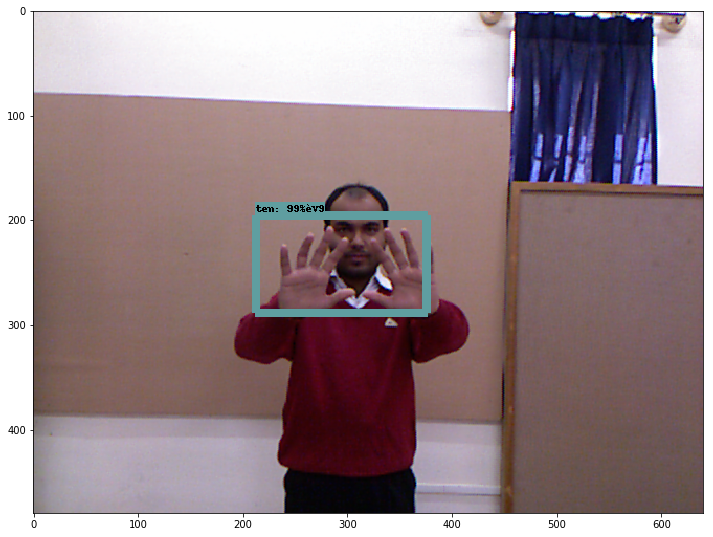

In [106]:
# Run inference
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

#if tf.__version__ < '1.4.0':
# raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')
  

  
  
# This is needed to display the images.
%matplotlib inline




from utils import label_map_util

from utils import visualization_utils as vis_util




# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.

PATH_TO_CKPT = '/content/models/research/heraclesLab/fine_tuned_model' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/content/models/research/heraclesLab', 'signLangDataSet.pbtxt')

NUM_CLASSES = 37




detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def1 = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    tf.no_op(name=None)
    od_graph_def1.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def1, name='')
    
    
    
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)




def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)




# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/content/models/research/heraclesLab/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 2) ]

# Size, in inches, of the output images.
#IMAGE_SIZE = (12, 8)
IMAGE_SIZE = (12, 12)




def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict




for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)